In [0]:
# srcipt_coco_downloader.txt
# Contains command line script to download COCO Datasets


# Download and install COCO API

!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools /content/api


# # Download and unzip Train 2014 Dataset

# !rm -rf /coco
# !mkdir /coco
# !rm /content/train.zip
# !rm /content/annotations.zip

# !wget http://images.cocodataset.org/zips/train2014.zip
# !unzip train2014.zip -d /coco
# !mv /coco/train2014 /coco/train
# !rm /content/train2014.zip

# !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
# !unzip annotations_trainval2014.zip -d /coco 
# !rm /content/annotations_trainval2014.zip


# Download and unzip Validation 2017 Dataset 

!rm -rf /coco
!mkdir /coco
!rm /content/val.zip
!rm /content/annotations.zip

!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip -d /coco
!mv /coco/val2017 /coco/val
!rm /content/val2017.zip

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip -d /coco 
!rm /content/annotations_trainval2017.zip

!mv /coco /content/coco

Cloning into 'cocoapi'...
remote: Enumerating objects: 947, done.
remote: Total 947 (delta 0), reused 0 (delta 0), pack-reused 947
Receiving objects: 100% (947/947), 11.69 MiB | 693.00 KiB/s, done.
Resolving deltas: 100% (565/565), done.
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-package

In [0]:
# Experimental sample code:

In [0]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from helper import getModelName
from data_loader import loadData, generateSelImgDict
from visualizer import imshow, getBitMask, getMaskedImg, getProminentMask, cropResizeSquare, resizeSquare, dataParseProminent, tensorToNpImg, thresholdProbMask, extractProminent, plotCurve, plotPerformance
from metrics import getPercentMask, calculateIoU, calculateTotalIoU, getLoss
from extractNet_simple import extractNet_simple
from trainer import trainModel

In [3]:
cocoData = loadData()

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!


In [4]:
#print categories in the supercategories of interest
cats = (cocoData.coco).loadCats((cocoData.coco).getCatIds())

for cat in cats:
	if (cat['supercategory'] == 'person' or cat['supercategory']=='vehicle' or cat['supercategory']=='animal'):
		print(cat['name'])

person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe


In [0]:
supCatInterest = ['person', 'vehicle', 'animal']
imgDict, annDict = generateSelImgDict(cocoData, supCatInterest)

In [0]:
#Code adapted from:
#https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
#example image from those chosen

# Example image
imgInd = 1
img = imgDict[imgInd]
img = io.imread(img['coco_url'])

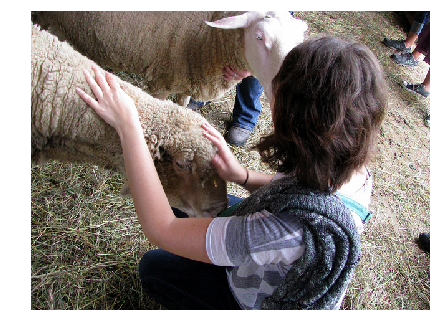

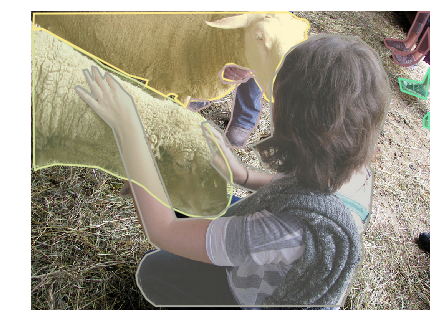

In [7]:
# Display image without annotations
imshow(img)

# Display image with annotations
plt.imshow(img)
plt.axis('off')
cocoData.coco.showAnns(annDict[imgInd])

In [0]:
mask = getBitMask(annDict[imgInd], cocoData)
masked_img = getMaskedImg(img, mask)

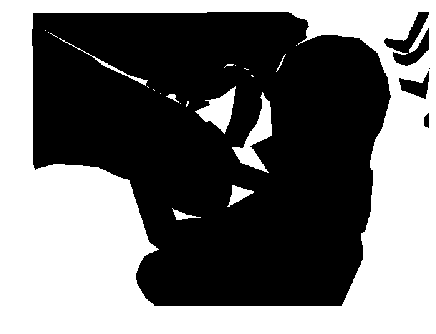

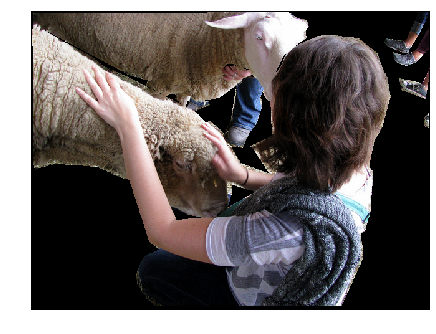

<Figure size 576x396 with 0 Axes>

In [9]:
imshow(mask)
imshow(masked_img)

In [0]:
# Test getProminentMask() on the previous image
# Only the person object should be extracted in the mask now
mask_modified = getProminentMask(annDict[imgInd], cocoData)

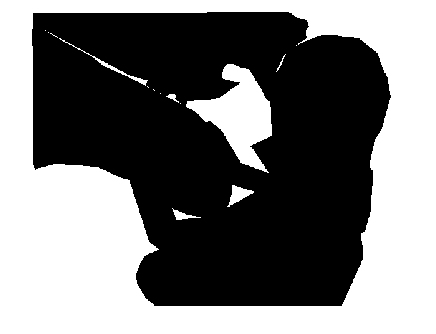

<Figure size 576x396 with 0 Axes>

In [11]:
imshow(mask_modified)

(-0.5, 223.5, 223.5, -0.5)

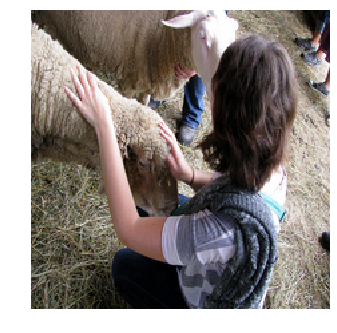

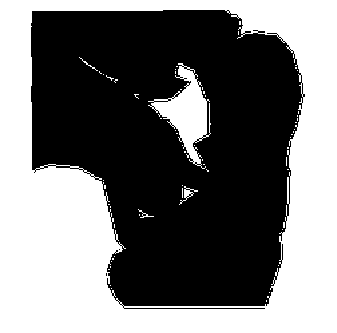

In [12]:
#with resizing
im, msk = resizeSquare(img, mask_modified)

plt.figure()
plt.imshow(im); plt.axis('off')

plt.figure()
plt.imshow(msk); plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

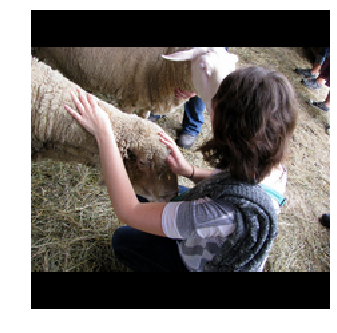

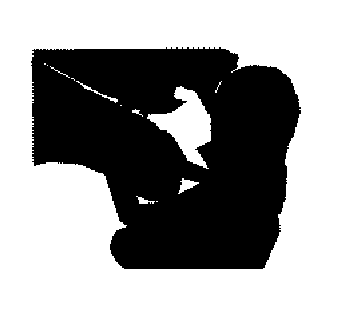

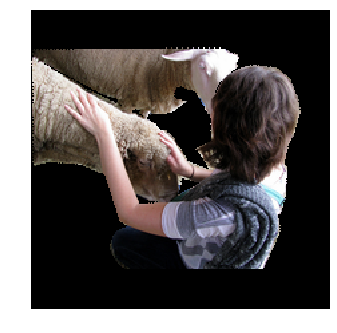

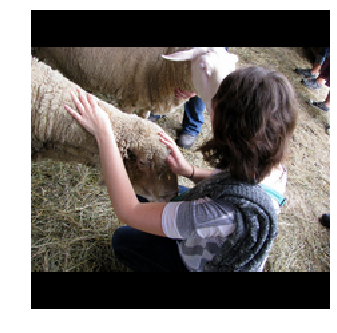

In [13]:
#with padding, maintain aspect ratio
im, msk = cropResizeSquare(img, mask_modified)
plt.figure()
plt.imshow(im); plt.axis('off')

plt.figure()
plt.imshow(msk); plt.axis('off')

plt.figure()
plt.imshow(getMaskedImg(im, msk)); plt.axis('off')

plt.figure()
tensor = torch.from_numpy(im)
mask = torch.from_numpy(msk)
plt.imshow(tensor); plt.axis('off')

In [0]:
data = dataParseProminent(cocoData, imgDict, annDict, 20)

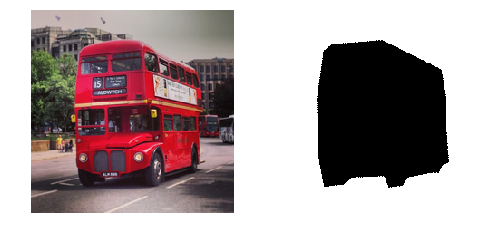

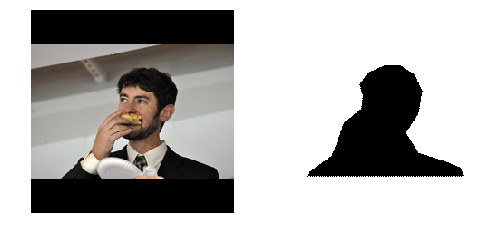

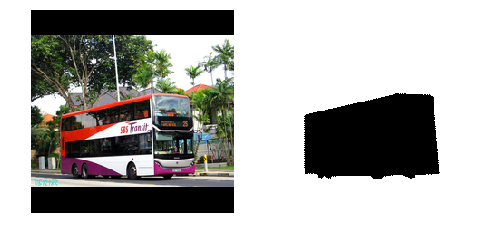

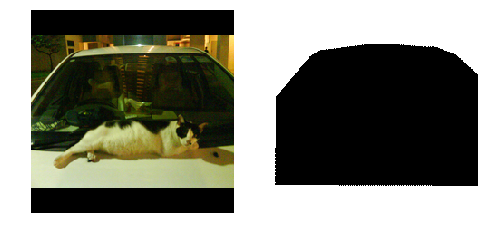

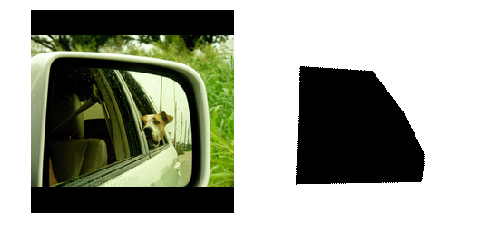

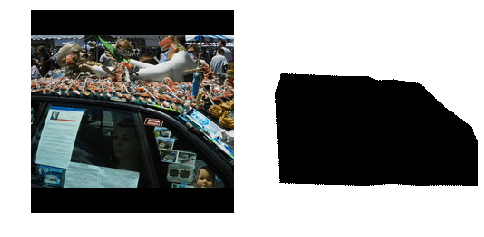

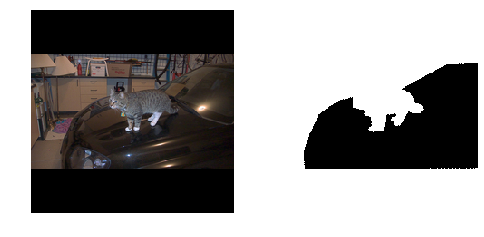

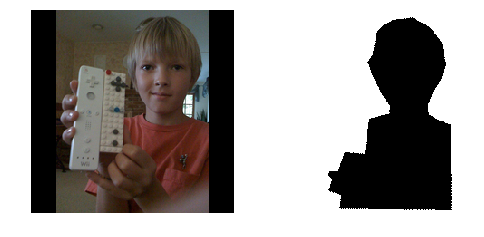

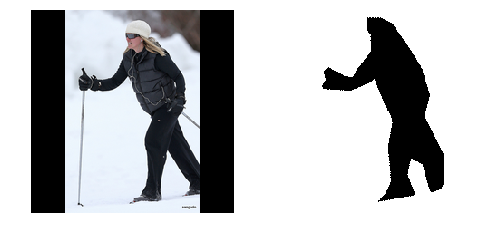

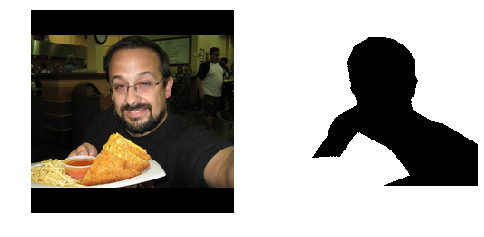

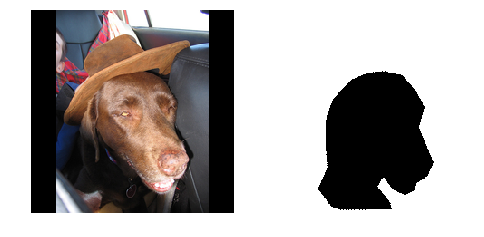

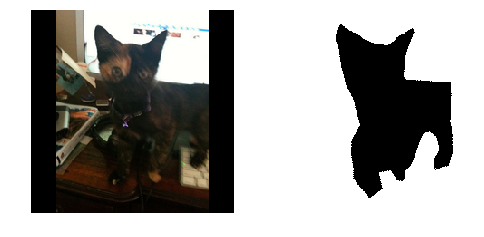

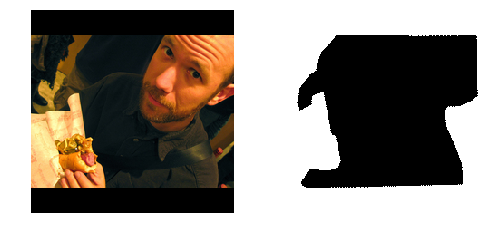

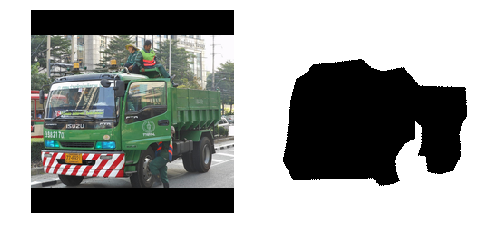

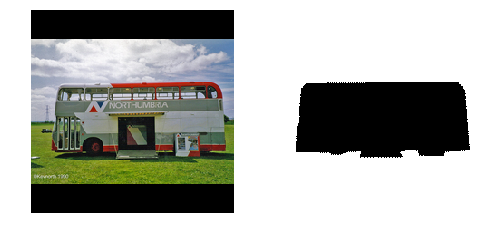

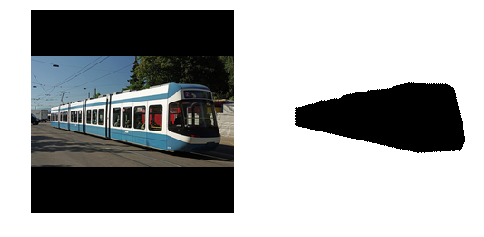

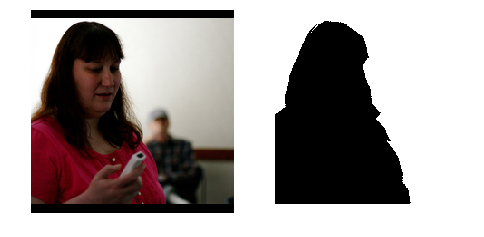

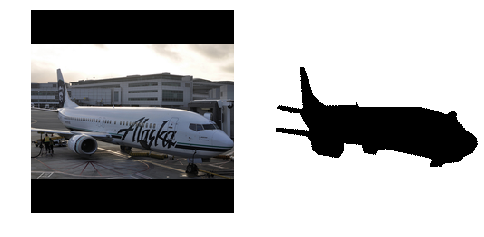

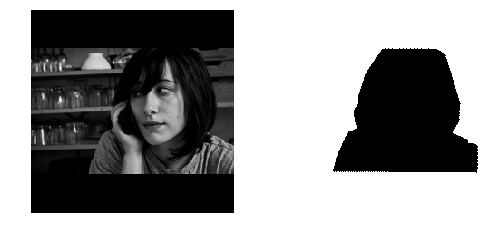

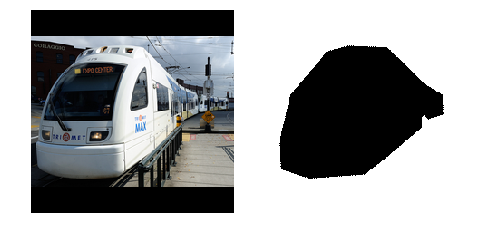

In [15]:
# Data visualization
for i, datapt in enumerate(data):
  img, target = datapt
  
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(img);   plt.axis('off')
  
  plt.subplot(1,2,2)
  plt.imshow(target); plt.axis('off')
  
plt.show()

In [0]:
# Create a small dataset for training and validation
dataset = dataParseProminent(cocoData, imgDict, annDict, 50, just_resize =True, toTensor=True)
train = dataset[:40]
valid = dataset[40:]

In [0]:
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)

In [0]:
net = extractNet_simple()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU: 0.25994876


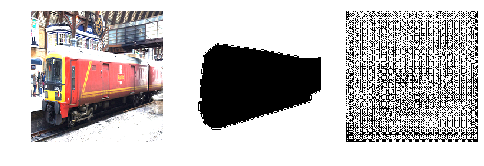

In [19]:
# Before training
img, target = train[0]
extractProminent(net, img, target)

Epoch:0, Train IoU:0.2926, Train Loss:0.2732|Valid IoU:0.3029, Valid Loss:0.3831
Epoch:1, Train IoU:0.1895, Train Loss:0.4492|Valid IoU:0.1855, Valid Loss:0.6532
Epoch:2, Train IoU:0.2665, Train Loss:0.3171|Valid IoU:0.2715, Valid Loss:0.4625
Epoch:3, Train IoU:0.2906, Train Loss:0.2253|Valid IoU:0.2968, Valid Loss:0.3106
Epoch:4, Train IoU:0.2975, Train Loss:0.2162|Valid IoU:0.3046, Valid Loss:0.2950
Epoch:5, Train IoU:0.3060, Train Loss:0.2131|Valid IoU:0.3134, Valid Loss:0.2880
Epoch:6, Train IoU:0.3174, Train Loss:0.2109|Valid IoU:0.3272, Valid Loss:0.2803
Epoch:7, Train IoU:0.3226, Train Loss:0.2109|Valid IoU:0.3364, Valid Loss:0.2772
Epoch:8, Train IoU:0.3231, Train Loss:0.2107|Valid IoU:0.3379, Valid Loss:0.2763
Epoch:9, Train IoU:0.3227, Train Loss:0.2101|Valid IoU:0.3379, Valid Loss:0.2761
Epoch:10, Train IoU:0.3215, Train Loss:0.2096|Valid IoU:0.3372, Valid Loss:0.2759
Epoch:11, Train IoU:0.3199, Train Loss:0.2090|Valid IoU:0.3339, Valid Loss:0.2769
Epoch:12, Train IoU:0.3187

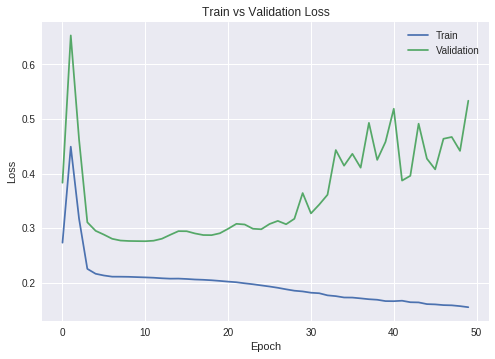

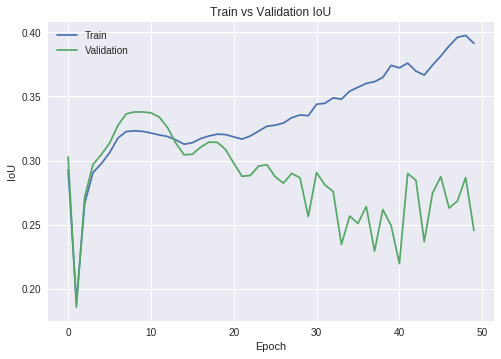

In [22]:
trainModel(net, train[:10], valid[:5], batch_size=32, num_epochs=50, checkpoint=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU: 0.52776474


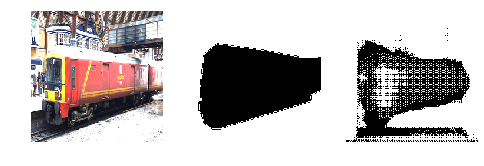

In [23]:
# After training
img, target = train[0]
extractProminent(net, img, target)